# Hilda 3:2 resonant family asteroids

Figure 3.3 from Chapter 3 of Ryden, *Celestial and Stellar Dynamics*, Cambridge University Press.

Location of the Hildas (black points) relative to the orbits of Jupiter and Saturn.

Osculating orbit elements for the Hildas are taken from the IAU Minor Planet Center `MPCORB` database,
and the osculating elements for Mars and Jupiter were computed using the JPL Horizons System.  We use a simple
Newton-Raphson root finder to numerically solve the Kepler equation to derive the eccentric anomaly.  This is 
good enough for presentation purposes.

Much of the computation in this notebook is needed to compute ecliptic cartesian coordinates for an object
given osculating orbit elements and a date.  We transform the ecliptic coordinates into the Sun-Jupiter
co-rotating frame for the plot.  Only the orbits of Jupiter and Mars are shown.

In [6]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

from pathlib import Path

# Need astropy time module

from astropy.time import Time

# used for Newton-Raphson root solving for this plot

from scipy.optimize import newton

# suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)
warnings.filterwarnings('ignore',category=RuntimeWarning, append=True)

## Standard Plot Format

Setup the standard plotting format and make the plot.  

In [7]:
plotFile = 'Fig3_3.png' 

# graphic aspect ratio (w/h)

aspect = 1.0

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 0.85

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 12
labelFontSize = 10
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## Orbit calculation and transform functions


### Eccentric anomaly, $E$

The mean anomaly $M$ is related to the eccentric anomaly $E$ and eccentricity $e$ by Kepler's equation:
 > $M = E - e\sin(E)$

Kepler's equation cannot be solved analytially to compute $E$ given $M$ and $e$ from the orbit elements, so
we solve it numerically using the Newton-Raphson method.  

Define a function $f(E)$
 > $f(E) = E - e\sin(E) - M$

with derivative
 > $\frac{dfE}{dE} = 1 - e\cos(E)$

And solve for $f(E)=0$ given $M$ and $e$.  We will use the `scipy.optimize.newton()` function to solve
for the roots using the Newton-Raphson method.

### True anomaly, $\nu$

Compute the true anomaly $\nu$ given the eccentric anomaly $E$ and orbit eccentricity $e$, using a form that
is numerically safe when E is near $\pm\pi$:
\begin{equation}
  \nu = E + 2\arctan\left(\frac{\beta\sin E}{1-\beta\cos E}\right)
\end{equation}
where
\begin{equation}
  \beta = \frac{e}{1+(1-e^2)^{1/2}}
\end{equation}

### Orbital elements to ecliptic reference plane (x,y,z) coordinates

For a given epoch and osculating orbit elements (a,e,i,n,$\Omega$,$\omega$), `orbXYZ()` computes the
ecliptic reference plane (x,y,z) location of the object at that epoch. It solves Kepler's equation for the
eccentric anomaly $E$ and from that and the true anomaly $\nu$ calculates the location in perifocal (orbital)
plane coordinates (x$_{\rm orb}$,y$_{\rm orb}$).

These are then transformed into ecliptic reference plane XYZ coordinates using the `orbToEclitpic()` function
which performs the Euler matrix transform using the three angles ($\Omega$,$i$,$\omega$).

### Convenience Functions

`traceOrb()` traces a complete orbit in (XYZ) ecliptic coordinates given Keplerian osculating orbit elements
(a,e,i,$Omega$,$omega$).

`corotXY()` rotates ecliptic plane (x,y) coordiate into the the co-rotating reference frame of a planet 
with ecliptic plane coordinates (xP,yP).

In [8]:
# Kepler's equation - assumes M and E in radians

def kepler(E,M,e):
    return (E - e*np.sin(E) - M)

# Derivative of Kepler's equation, E in radians

def kepler_deriv(E,M,e):
    return (1.0 - e*np.cos(E))

# Compute the eccentric anomaly - M must be in radians

def eccAnomaly(M,e):
    E = newton(kepler, M, kepler_deriv, args=(M,e))
    return E

# Compute the true anomaly - E must be in radians

def trueAnomaly(E,e):
    beta = e/(1.0+np.sqrt(1-e*e))
    sin_nu = beta*np.sin(E)
    cos_nu = 1 - beta*np.cos(E)
    nu = E + 2.0*np.arctan2(sin_nu,cos_nu)
    return nu

# Convert orbital plane (x,y) to ecliptic plane (x,y,z)
    
def orbToEcliptic(xorb,yorb,Omega,i,omega):

    # Euler matrix - angles must be in radians
    
    m_xx = np.cos(omega)*np.cos(Omega) - np.sin(omega)*np.cos(i)*np.sin(Omega)
    m_xy = np.cos(omega)*np.sin(Omega) + np.sin(omega)*np.cos(i)*np.cos(Omega)
    m_xz = np.sin(omega)*np.sin(i)
    
    m_yx = -np.sin(omega)*np.cos(Omega) - np.cos(omega)*np.cos(i)*np.sin(Omega)
    m_yy = -np.sin(omega)*np.sin(Omega) + np.cos(omega)*np.cos(i)*np.cos(Omega)
    m_yz =  np.cos(omega)*np.sin(i)
    
    # because zorb=0 by definition, we don't need these
    #m_zx =  np.sin(i)*np.sin(Omega)
    #m_zy = -np.sin(i)*np.cos(Omega)
    #m_zz =  np.cos(i)
    
    # compute ecliptic XYZ
    
    xEcl = xorb*m_xx + yorb*m_yx # + zorb*m_zx
    yEcl = xorb*m_xy + yorb*m_yy # + zorb*m_zy
    zEcl = xorb*m_xz + yorb*m_yz # + zorb*m_zz
    
    return xEcl,yEcl,zEcl

# Compute ecliptic (x,y,z) coordinates at epochXY given orbit elements (a,e,n,M) at epoch elEpoch

def orbXYZ(a,e,n,M,i,Omega,omega,elEpoch,epochXY):
    dT = epochXY - elEpoch # years
    dM = np.radians(dT*n*365.25) # radians
    Mep = M + dM # mean anomaly at epochXY in radians
    
    # eccentric anomaly, E, at epochXY in radians
    
    E = eccAnomaly(Mep,e)
    
    # true anomaly, nu, at epochXY in radians
    
    nu = trueAnomaly(E,e)
    
    # heliocentric radius in au
    
    r = a*(1-e*e)/(1 + e*np.cos(nu))
    
    # orbit plane (x,y), perihelion is toward +x
    
    xorb = r*np.cos(nu)
    yorb = r*np.sin(nu)
    
    x,y,z = orbToEcliptic(xorb,yorb,Omega,i,omega)

    return x,y,z

# trace a full orbit in ecliptic cartesian coordinats

def traceOrb(a,e,i,Omega,peri):
    nu = np.linspace(0.0,2.*np.pi,501)
    r = a*(1-e*e)/(1+e*np.cos(nu))
    xorb = r*np.cos(nu)
    yorb = r*np.sin(nu)
    
    x,y,z = orbToEcliptic(xorb,yorb,np.radians(Omega),np.radians(i),np.radians(peri))

    return x,y,z

# rotate ecliptic (x,y) coordinates into the co-rotating heliocentric frame of planet at (xP,yP)

def corotXY(x,y,xP,yP):
    dX = x - xP
    dY = y - yP

    rP = np.sqrt(xP*xP + yP*yP) # heliocentric distance
    theta = np.arctan2(yP,xP)   # rotation angle

    xcr =  dX*np.cos(theta) + dY*np.sin(theta) + rP
    ycr = -dX*np.sin(theta) + dY*np.cos(theta)

    return xcr,ycr

## Hilda family asteroids

Read in the MPCORB database orbit elements for the Hilda family asteroids from a prepared CSV file (see the
`procOrb.ipynb` notebook in the `SolSys` folder).  Convert angular orbit elements to radians as needed.

Set the date to plot the view of the ecliptic plane (X,Y) for these bodies, then compute the ecliptic
XYZ coordinates on the view epoch.

Plot details:
 * Plot the locations of the Hildas a black filled circles, and the locations of Jupiter, Mars and the Sun
 * Plot the orbits of Jupiter and Mars
 * Label the Jupiter-Sun Lagrange points

In [9]:
# orbit elements are in a pre-computed CSV file extracted from the MPCORB database

orbFile = str(Path("Asteroids") / "MPC_Hildas.csv")

# date for for the solar system view

viewDate = '2023-05-02'

# read the CSV file and setup orbit element vectors

data = pd.read_csv(orbFile)

elEpoch = np.array(data['Epoch']) # epoch of the orbit elements in years

a = np.array(data['a']) # semimajor axis
e = np.array(data['e']) # eccentricity
n = np.array(data['n']) # mean motion in degrees/day

# convert angular orbit element angles to radians

i = np.radians(np.array(data['i']))  # inclination of the orbital plane
Omega = np.radians(np.array(data['Omega'])) # longitude of the ascending node
peri = np.radians(np.array(data['peri']))   # argument of periastron
M = np.radians(np.array(data['M']))         # mean anomaly at epoch

print(f'read {len(a)} object orbit elements')

# compute the viewing epoch in decimal years

t = Time(viewDate,format='isot',scale='tt') # astropy time object
viewEpoch = t.decimalyear
print(f'Computing positions for Epoch {viewDate} ({viewEpoch:.5f})')

# compute XYZ positions on the ecliptic plane

xH,yH,zH = orbXYZ(a,e,n,M,i,Omega,peri,elEpoch,viewEpoch)

# axis limits:

aMax = 6.5

read 5035 object orbit elements
Computing positions for Epoch 2023-05-02 (2023.33151)


## Jupiter and Mars

Osculating elements from the JPL Horizons system for the reference epoch 2023-05-02

In [10]:
# Jupiter

a_J = 5.202255285475041 # au
e_J = 4.829581420244550E-02
i_J = 1.303571368954129 # deg
M_J = 8.438226373968186 # deg
Omega_J = 100.5179503267933 # deg
peri_J = 273.4560588880177  # deg
n_J = 8.310436114011867E-02 # deg/day

# Mars

a_M = 1.523657861751621 # au
e_M = 9.338196128062515E-02
i_M = 1.847929144227385 # deg
M_M = 164.8775155376688 # deg
Omega_M = 49.48946137773974 # deg
peri_M = 286.6314788566015  # deg
n_M = 5.240502815639928E-01 # deg/day

aPl = np.array([a_J,a_M])
ePl = np.array([e_J,e_M])
iPl = np.radians([i_J,i_M])
MPl = np.radians([M_J,M_M])
OmPl = np.radians([Omega_J,Omega_M])
wPl = np.radians([peri_J,peri_M])
nPl = np.array([n_J,n_M])
epPl = np.array([viewEpoch,viewEpoch])

# Jupiter and Mars locations at viewEpoch

xPl,yPl,zPl = orbXYZ(aPl,ePl,nPl,MPl,iPl,OmPl,wPl,epPl,viewEpoch)

# Jupiter-Sun L4 and L5

xL4,yL4,zL4 = orbXYZ(a_J,e_J,n_J,np.radians(M_J+60.0),iPl[0],wPl[0],OmPl[0],epPl[0],viewEpoch)
xL5,yL5,zL5 = orbXYZ(a_J,e_J,n_J,np.radians(M_J-60.0),iPl[0],wPl[0],OmPl[0],epPl[0],viewEpoch)

# transform into the Sun-Jupiter co-rotating reference frame

xJ = xPl[0]
yJ = yPl[0]
rJ = np.sqrt(xJ*xJ + yJ*yJ)

xM = xPl[1]
yM = yPl[1]

xHcr, yHcr = corotXY(xH,yH,xJ,yJ)
xMcr, yMcr = corotXY(xM,yM,xJ,yJ)

xL4cr, yL4cr = corotXY(xL4,yL4,xJ,yJ)
xL5cr, yL5cr = corotXY(xL5,yL5,xJ,yJ)

# complete Jupiter and Mars orbits, in the Sun-Jupiter co-rotating frame

xoJ,yoJ,zoJ = traceOrb(a_J,e_J,i_J,Omega_J,peri_J)
xoJcr,yoJcr = corotXY(xoJ,yoJ,xJ,yJ)

xoM,yoM,zoM = traceOrb(a_M,e_M,i_M,Omega_M,peri_M)
xoMcr,yoMcr = corotXY(xoM,yoM,xJ,yJ)


## Make the plot


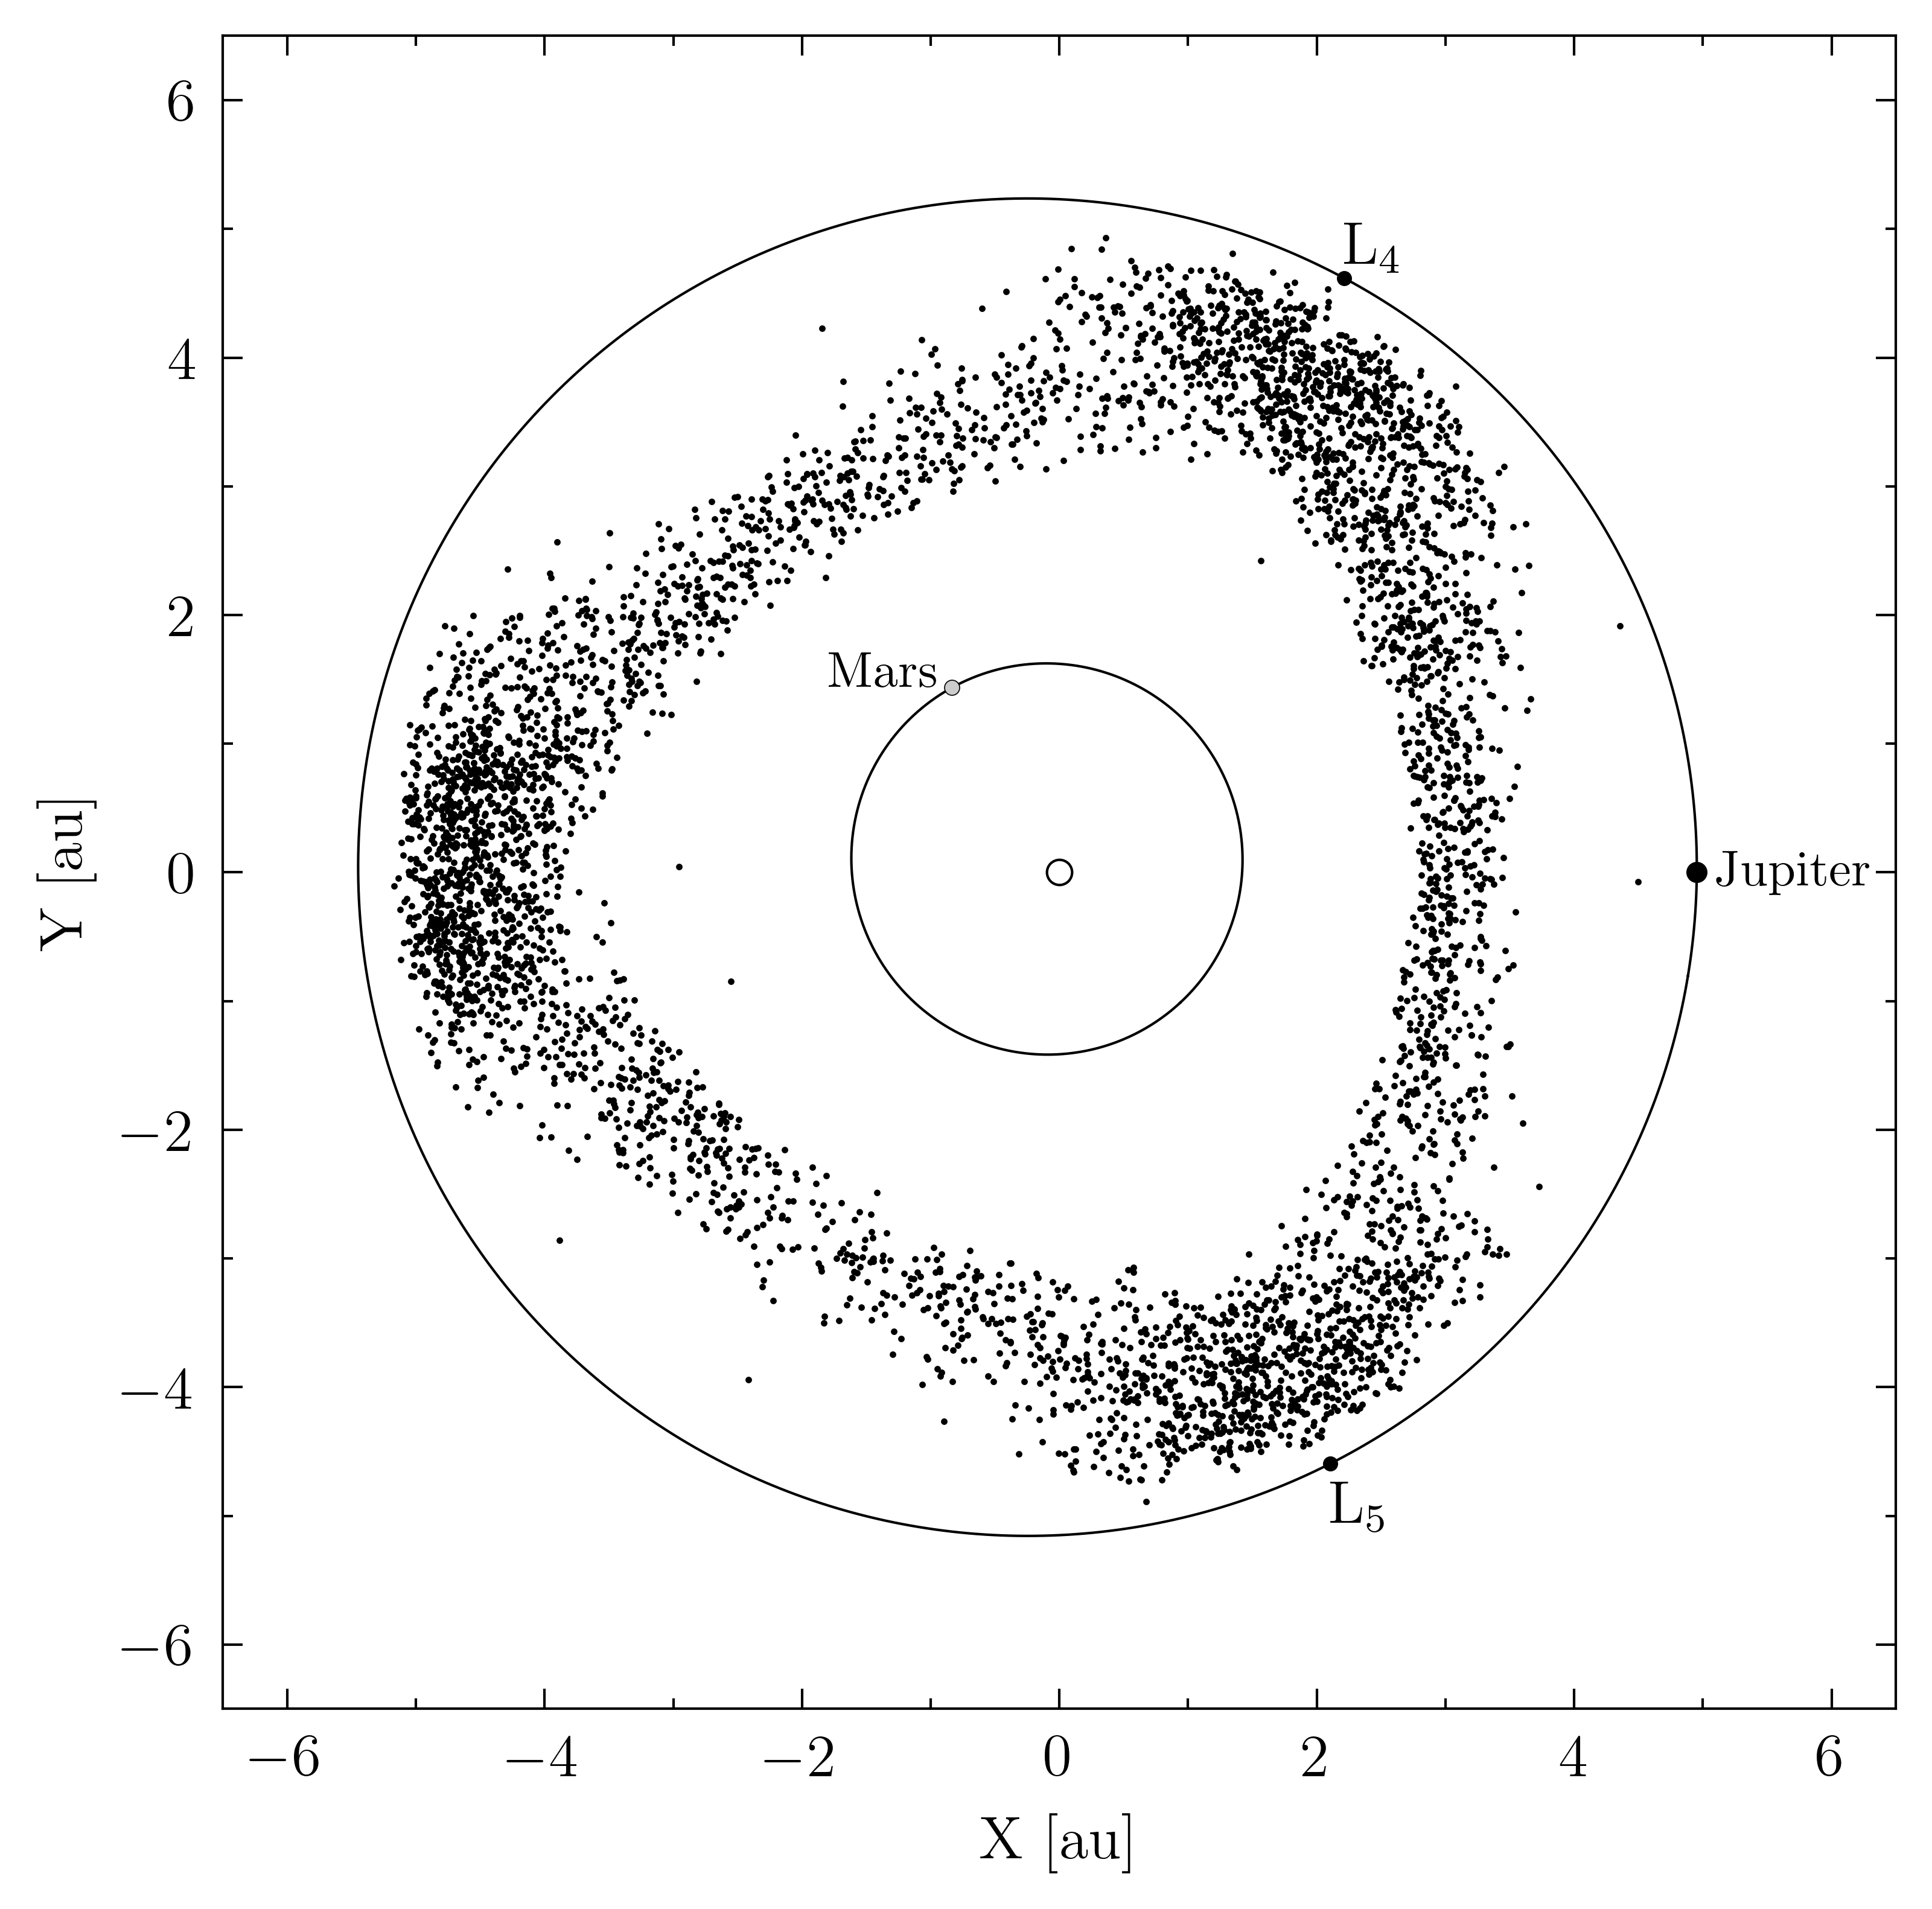

In [11]:
fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=4,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=2,width=lwidth,which='minor',direction='in',top='on',right='on')

ax.set_xlim(-aMax,aMax)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlabel(r'X [au]',fontsize=axisFontSize)

ax.set_ylim(-aMax,aMax)
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylabel(r'Y [au]',fontsize=axisFontSize)

ax.set_aspect(True)

# plot the Hildas

ax.plot(xHcr,yHcr,'o',ms=1,mfc='black',mec='black',mew=0.3,alpha=1,zorder=7)

# Jupiter and Mars on their orbits

ax.plot(xoJcr,yoJcr,'-',lw=0.5,color='black',zorder=9)
ax.plot(rJ,0,'o',ms=4,mec='black',mfc='black',mew=0.2,zorder=10)
ax.text(rJ+0.15,0,'Jupiter',va='center',ha='left',fontsize=labelFontSize)

ax.plot(xoMcr,yoMcr,'-',lw=0.5,color='black',zorder=9)
ax.plot(xMcr,yMcr,'o',ms=3,mec='black',mfc='#cccccc',mew=0.2,zorder=10)
ax.text(xMcr-0.1,yMcr+0.1,'Mars',va='center',ha='right',fontsize=labelFontSize)

# Plot the Sun

ax.plot(0,0,'o',ms=5,mec='black',mfc='white',mew=0.5,zorder=10)

# Jupiter leading and trailing Lagrange points

#xL4 = xL5 = 0.5*rJ
#yL4 = 0.5*np.sqrt(3)*rJ
#yL5 = -yL4

ax.plot(xL4cr,yL4cr,'o',color='black',ms=2,zorder=10)
ax.text(xL4cr,1.05*yL4cr,r'L$_4$',color='black',va='center',ha='left',fontsize=axisFontSize)
ax.plot(xL5cr,yL5cr,'o',color='black',ms=2,zorder=10)
ax.text(xL5cr,1.075*yL5cr,r'L$_5$',color='black',va='center',ha='left',fontsize=axisFontSize)

# make the hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')

plt.show()